In [1]:
import sys
sys.path.insert(0,'/home/zahradnik/PycharmProjects/master_thesis')

In [14]:
import numpy as np
import pandas as pd
import os
from src.modules import conf, fit, df_columns, evl, preprocess
from sklearn.model_selection import train_test_split
from datetime import datetime
from xgboost import XGBRegressor

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
race_day = '2023-12-03-11-30'

In [23]:
data = fit.load_pcls(
        'zahradnik',
        'running',
        conf["Paths"]["pcl"],
        datetime.strptime(race_day, "%Y-%m-%d-%H-%M")
    )
test_df = data[31]
data.pop(31)
print("")

100%|██████████| 386/386 [00:00<00:00, 786.21it/s] 

In [24]:
cad_test = test_df["cadence"]
hr_test = test_df["heart_rate"]
speed_test = test_df["enhanced_speed"]
cols_to_drop = ["cadence","heart_rate","enhanced_speed"]
for x in cols_to_drop:
    cols_drop = test_df.filter(like=x).columns
    test_df.drop(columns=cols_drop,inplace=True)

In [25]:
low_dist, high_dist = preprocess.segment_data(data)
len(low_dist),len(high_dist)

(144, 241)

In [26]:
if max(test_df.distance) > 10000:
    train_df = fit.clean_data(pd.concat(high_dist))
else:
    train_df = fit.clean_data(pd.concat(low_dist))
len(train_df)

681291

In [9]:
# Objective function for XGBoost regression
def objective_function(params):
    # Extract hyperparameters
    learning_rate, max_depth, min_child_weight = params
    
    # Train XGBoost model
    model = xgb.XGBRegressor(learning_rate=abs(learning_rate), max_depth=round(max_depth), min_child_weight=min_child_weight, random_state=42)
    model.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = model.predict(X_valid)

    # Calculate mean squared error (you can replace this with your own evaluation metric)
    mae = mean_absolute_error(y_valid, y_pred)

    # Return mae since we are maximizing the objective
    return -mae

In [10]:
import matplotlib.pyplot as plt

def visualize_optimization(iterations, parameter_values, objective_values):
    # Plotting the values of each parameter over iterations
    plt.figure(figsize=(10, 6))
    for param_idx in range(len(parameter_values[0])):
        plt.plot(range(iterations+1), [params[param_idx] for params in parameter_values], label=f'Parameter {param_idx + 1}')

    plt.title('Optimization Process - Parameter Values')
    plt.xlabel('Iteration')
    plt.ylabel('Parameter Value')
    plt.legend()
    plt.show()

    # Plotting the objective function values over iterations
    plt.figure(figsize=(10, 6))
    plt.plot(range(iterations), objective_values, label='Objective Function Value', color='red')

    plt.title('Optimization Process - Objective Function')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Function Value')
    plt.legend()
    plt.show()

# Random shooting

In [13]:
import xgboost as xgb
# Train XGBoost model
from sklearn.metrics import mean_absolute_error

X_train, X_valid, y_train, y_valid = train_df[test_df.columns], test_df, train_df["cadence"], speed_test 

model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Predict on the validation set
y_pred = model.predict(X_valid)

# Calculate mean squared error (you can replace this with your own evaluation metric)
mae = mean_absolute_error(y_valid, y_pred)
mae

0.6799155753229579

In [36]:
import numpy as np
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from tqdm import tqdm

def random_shooting(iterations, search_range):
    # Initialize best parameters and score
    best_params = None
    best_score = float('-inf')
    
    all_params=[]
    obj_values=[]

    for iteration in tqdm(range(iterations)):
        # Sample random hyperparameters in the specified search range
        current_params = [np.random.uniform(low, high) for low, high in search_range]

        # Evaluate the objective function at the current point
        current_score = objective_function(current_params)

        # Update the best point if the current point is better
        if current_score > best_score:
            best_params = current_params
            best_score = current_score
            
        obj_values.append(current_score)
        all_params.append(current_params)

    return best_params, best_score,all_params, obj_values
# Example usage
iterations = 100
search_range = [(0.001, 0.2), (3, 10), (1, 5)]

In [37]:
# Split the training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_df[test_df.columns], test_df, train_df["cadence"], cad_test 

best_params, best_score,_,_ = random_shooting(iterations, search_range)

print("Best Parameters:", best_params)
print("Best Score for Cadence (Mean Absolute Error):", best_score)

test_df["cadence"] = cad_test
test_df= preprocess.calc_windows(df=test_df,
          lagged=15,
          cols=["cadence"])
test_df = preprocess.calc_moving(df=test_df, max_range=110, col="cadence")

100%|██████████| 100/100 [09:24<00:00,  5.64s/it]

Best Parameters: [0.03484734086774919, 5.41812649178143, 3.205441547360793]
Best Score for Cadence (Mean Absolute Error): -0.6827098525755515


In [38]:
# Split the training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_df[test_df.columns], test_df, train_df["heart_rate"], hr_test 

best_params, best_score, _, _ = random_shooting(iterations, search_range)

print("Best Parameters:", best_params)
print("Best Score for Heart_rate (Mean Absolute Error):", best_score)


from feature_engine.creation import MathFeatures
test_df["heart_rate"] = hr_test
for fce in ["sum", "mean", "min", "max"]:
    test_df = MathFeatures(variables=["heart_rate", "cadence"], func=fce).fit(test_df).transform(test_df)
    
test_df= preprocess.calc_windows(df=test_df,
          lagged=12,
          cols=["heart_rate"])
test_df = preprocess.calc_moving(df=test_df, max_range=110, col="heart_rate")

100%|██████████| 100/100 [14:25<00:00,  8.66s/it]

Best Parameters: [0.1032523690376692, 9.202962480499192, 1.438785979467677]
Best Score for Heart_rate (Mean Absolute Error): -3.706010665677832


In [39]:
# Split the training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_df[test_df.columns], test_df, train_df["enhanced_speed"], speed_test 

best_params, best_score,all_params,obj_values = random_shooting(iterations, search_range)
print("Best Parameters:", best_params)
print("Best Score for Speed (Mean Absolute Error):", best_score)

100%|██████████| 100/100 [19:31<00:00, 11.71s/it]

Best Parameters: [0.17590450816672537, 3.286631282146538, 3.4674464699896377]
Best Score for Speed (Mean Absolute Error): -0.5200148319251096


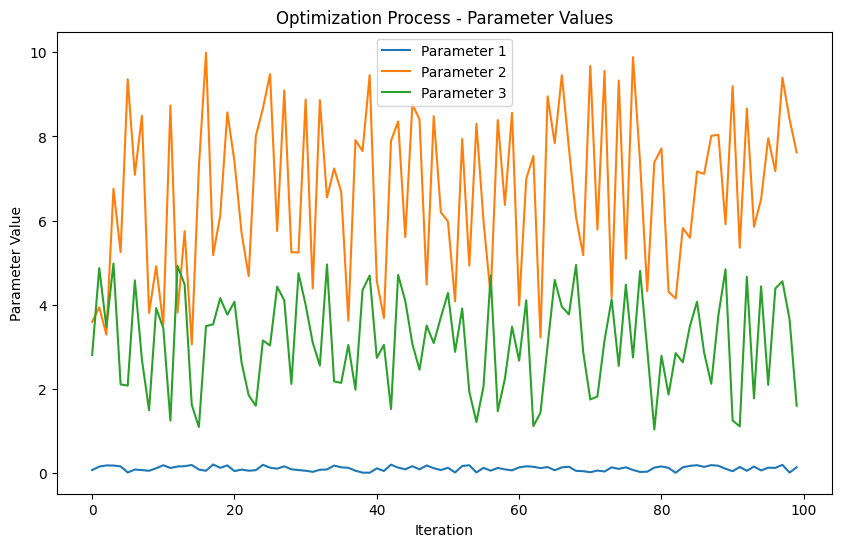

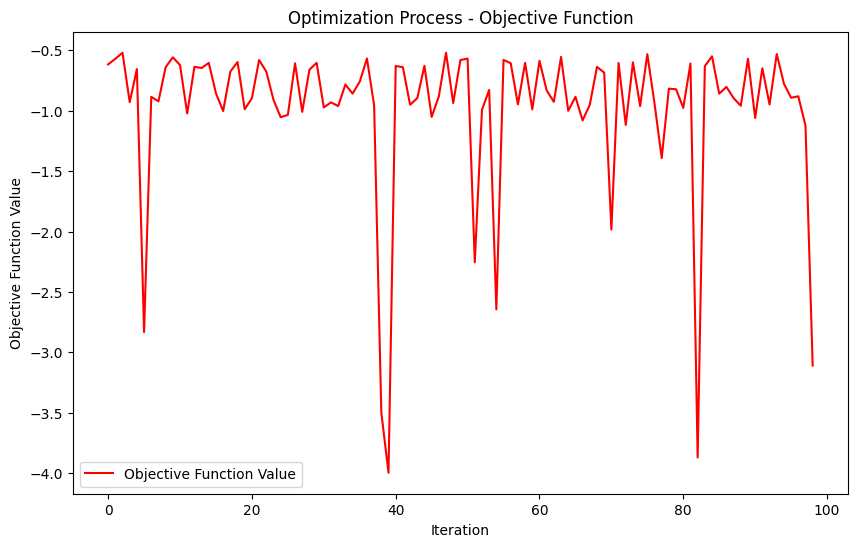

In [41]:
visualize_optimization(99, all_params, obj_values[:99])

## Genetics optimization with DEAP

In [22]:
from deap import base, creator, tools, algorithms
toolbox = base.Toolbox()
import random
attr_set = []
search_space = [(0.001, 0.2), (3, 10), (1, 5)]

for key,counter in zip(search_space,range(len(search_space))):
    print(key)
    if isinstance(key[0],float):
        toolbox.register(f"attr_{counter}", random.uniform, key[0], key[1])
    elif isinstance(key[0],int):
        toolbox.register(f"attr_{counter}", random.randint, key[0], key[1])

    attr_set.append(getattr(toolbox, (f"attr_{counter}")))
attr_set

(0.001, 0.2)
(3, 10)
(1, 5)


[functools.partial(<bound method Random.uniform of <random.Random object at 0x55b20e803b10>>, 0.001, 0.2),
 functools.partial(<bound method Random.randint of <random.Random object at 0x55b20e803b10>>, 3, 10),
 functools.partial(<bound method Random.randint of <random.Random object at 0x55b20e803b10>>, 1, 5)]

In [12]:
import numpy as np
import xgboost as xgb
from deap import base, creator, tools, algorithms
import numpy as np
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from tqdm import tqdm
def genetic_opt(pop_size: int, genetic_iterations: int, search_space: list):
    # Define individual and population
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    
    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, np.abs(search_space[0][0]), np.abs(search_space[0][1]))
    toolbox.register("attr_int1", np.random.randint, np.abs(search_space[1][0]), np.abs(search_space[1][1]))
    toolbox.register("attr_int2", np.random.randint, np.abs(search_space[2][0]), np.abs(search_space[2][1]))
    toolbox.register("individual", tools.initCycle, creator.Individual, attr_set, n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    # Register genetic operators
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    # Evaluation function
    toolbox.register("evaluate", objective_function)
    
    # Main genetic algorithm loop
    population = toolbox.population(n=pop_size)
    
    for gen in tqdm(range(genetic_iterations)):
        try:
            offspring = algorithms.varAnd(population, toolbox, cxpb=0.7, mutpb=0.2)
            fits = toolbox.map(toolbox.evaluate, offspring)
            
            for ind, fit in zip(offspring, fits):
                ind.fitness.values = [fit]
        
            population = toolbox.select(offspring, k=len(population))
        except BaseException as e:
            print(e)
        
    best_individual = tools.selBest(population, k=1)[0]
    return tools.selBest(population, k=1)[0],  best_individual
    
# Genetic algorithm parameters
pop_size = 20
genetic_iterations = 10
search_space = [(0.001, 0.2), (3, 10), (1, 5)]  # Search range for learning_rate, max_depth, and min_child_weight 

In [14]:
from tqdm import tqdm
X_train, X_valid, y_train, y_valid = train_df[test_df.columns], test_df, train_df["cadence"], cad_test 

# Get the best individual from the final population
best_individual, best_params = genetic_opt(pop_size, genetic_iterations, search_space)

print("Best Parameters:", best_params)
print("Best Score (Mean Absolute Error):", -best_individual.fitness.values[0])

test_df["cadence"] = cad_test
test_df= preprocess.calc_windows(df=test_df,
          lagged=15,
          cols=["cadence"]) 
test_df = preprocess.calc_moving(df=test_df, max_range=110, col="cadence")

100%|██████████| 10/10 [23:07<00:00, 138.77s/it]

Best Parameters: [0.08680864616885081, 1.9094446592221646, 1.2337162014647858]
Best Score (Mean Absolute Error): 0.6614180856313637


In [15]:
X_train, X_valid, y_train, y_valid = train_df[test_df.columns], test_df, train_df["heart_rate"], hr_test 
best_individual, best_params = genetic_opt(pop_size, genetic_iterations, search_space)
print("Best Parameters:", best_params)
print("Best Score (Mean Absolute Error):", -best_individual.fitness.values[0])

from feature_engine.creation import MathFeatures
test_df["heart_rate"] = hr_test
for fce in ["sum", "mean", "min", "max"]:
    test_df = MathFeatures(variables=["heart_rate", "cadence"], func=fce).fit(test_df).transform(test_df)
    
test_df= preprocess.calc_windows(df=test_df,
          lagged=12,
          cols=["heart_rate"])
test_df = preprocess.calc_moving(df=test_df, max_range=110, col="heart_rate")

100%|██████████| 10/10 [1:03:29<00:00, 380.98s/it]

Best Parameters: [0.1461423261077942, 8.0906334704331, 4.067432150062347]
Best Score (Mean Absolute Error): 3.051524731261229


In [27]:
from tqdm import tqdm
test_df["cadence"] = cad_test
test_df= preprocess.calc_windows(df=test_df,
          lagged=15,
          cols=["cadence"]) 
test_df = preprocess.calc_moving(df=test_df, max_range=110, col="cadence")
from feature_engine.creation import MathFeatures
test_df["heart_rate"] = hr_test
for fce in ["sum", "mean", "min", "max"]:
    test_df = MathFeatures(variables=["heart_rate", "cadence"], func=fce).fit(test_df).transform(test_df)
    
test_df= preprocess.calc_windows(df=test_df,
          lagged=12,
          cols=["heart_rate"])
test_df = preprocess.calc_moving(df=test_df, max_range=110, col="heart_rate")
X_train, X_valid, y_train, y_valid = train_df[test_df.columns], test_df, train_df["enhanced_speed"], speed_test 
best_individual, best_params = genetic_opt(pop_size, genetic_iterations, search_space)
print("Best Parameters:", best_params)
print("Best Score (Mean Absolute Error):", -best_individual.fitness.values[0])

 50%|█████     | 5/10 [35:37<26:41, 320.25s/it]  

value -0.202718 for Parameter min_child_weight should be greater equal to 0
min_child_weight: Minimum sum of instance weight(hessian) needed in a child.


100%|██████████| 10/10 [50:30<00:00, 303.03s/it]

Best Parameters: [0.13774319474859148, 1.9956124849591697, 2.3951247346450852]
Best Score (Mean Absolute Error): 0.45235837870421347


# Simulated Annealing

In [10]:
import math
import numpy as np
import xgboost as xgb
import random
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
def simulated_annealing(initial_params, objective_function, temperature, cooling_rate, num_iterations):
    current_params = np.array(initial_params)
    current_cost = objective_function(current_params)

    best_params = np.copy(current_params)
    best_cost = current_cost
    obj_values = []
    all_params = []

    for iteration in tqdm(range(num_iterations)):
        learning_rate, max_depth, min_child_weight = current_params
        new_learning_rate = np.clip(learning_rate + np.random.uniform(-0.01, 0.01), 0.01, 0.5)
        new_max_depth = np.clip(int(max_depth + np.random.randint(-1, 2)), 1, 10)
        new_min_child_weight = np.clip(min_child_weight + np.random.uniform(-0.5, 0.5), 1, 10)

        new_params = np.array([new_learning_rate, new_max_depth, new_min_child_weight])
        new_cost = objective_function(new_params)

        if new_cost < current_cost or random.uniform(0, 1) < math.exp((current_cost - new_cost) / temperature):
            current_params = new_params
            current_cost = new_cost

            if current_cost < best_cost:
                best_params = np.copy(current_params)
                best_cost = current_cost

        all_params.append(current_params)
        obj_values.append(current_cost)
        temperature *= cooling_rate

    return best_params, best_cost, all_params, obj_values


In [39]:

# Example usage
X_train, X_valid, y_train, y_valid = train_df[test_df.columns], test_df, train_df["cadence"], cad_test 

initial_params = [0.1, 5, 3]  # Initial values for learning_rate, max_depth, min_child_weight
temperature = 0.8
cooling_rate = 0.75
num_iterations = 100

best_params, best_cost,all_params_cad,obj_values_cad = simulated_annealing(initial_params, objective_function, temperature, cooling_rate, num_iterations)

print("Best Parameters:", best_params)
print("Best Score (Mean Absolute Error):", best_cost)
test_df["cadence"]= cad_test
    
test_df= preprocess.calc_windows(df=test_df,
          lagged=12,
          cols=["cadence"])

100%|██████████| 100/100 [12:21<00:00,  7.42s/it]

Best Parameters: [0.08939344 7.         1.80431476]
Best Score (Mean Absolute Error): -1.101133418036533


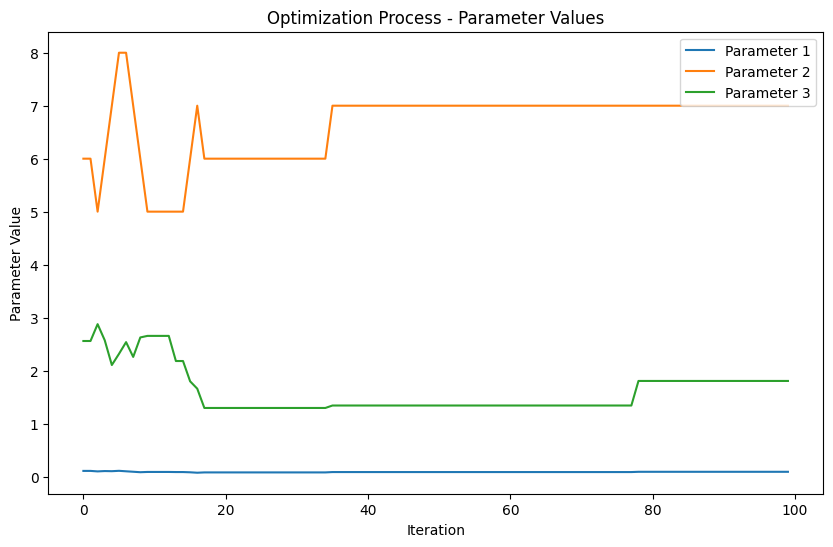

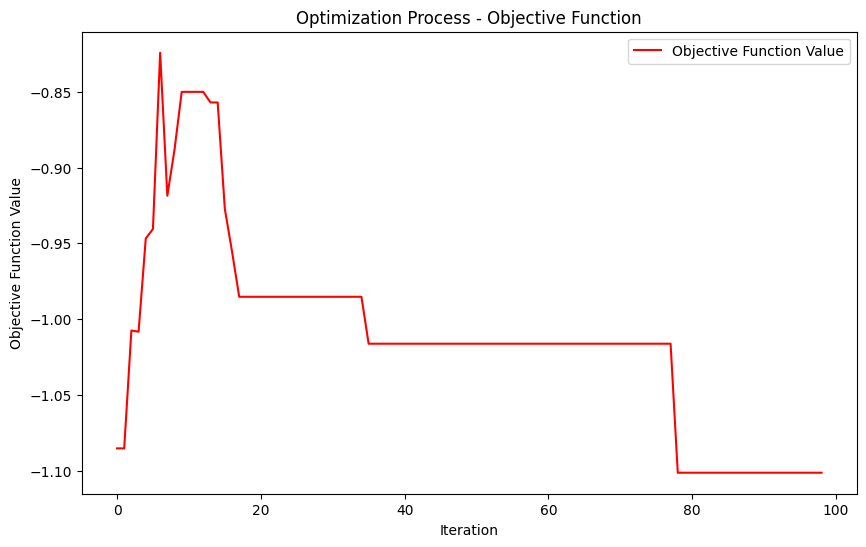

In [40]:
visualize_optimization(num_iterations-1, all_params_cad[:num_iterations], obj_values_cad[:num_iterations-1])

In [41]:
# Example usage
X_train, X_valid, y_train, y_valid = train_df[test_df.columns], test_df, train_df["heart_rate"], hr_test 

initial_params = [0.1, 10, 5]  # Initial values for learning_rate, max_depth, min_child_weight
temperature = 1.0
cooling_rate = 0.95
num_iterations = 200

best_params, best_cost,all_params_hr,obj_values_hr = simulated_annealing(initial_params, objective_function, temperature, cooling_rate, num_iterations)

print("Best Parameters:", best_params)
print("Best Score (Mean Absolute Error):", best_cost)

test_df["heart_rate"]=hr_test
from feature_engine.creation import MathFeatures
test_df["heart_rate"] = hr_test
for fce in ["sum", "mean", "min", "max"]:
    test_df = MathFeatures(variables=["heart_rate", "cadence"], func=fce).fit(test_df).transform(test_df)
    
test_df= preprocess.calc_windows(df=test_df,
          lagged=12,
          cols=["heart_rate"])
test_df = preprocess.calc_moving(df=test_df, max_range=110, col="heart_rate")
# Example usage:
# Assuming you have recorded parameter_values and objective_values during optimization

100%|██████████| 200/200 [46:42<00:00, 14.01s/it]

Best Parameters: [ 0.11621981 10.          6.7217375 ]
Best Score (Mean Absolute Error): -6.157675700857323


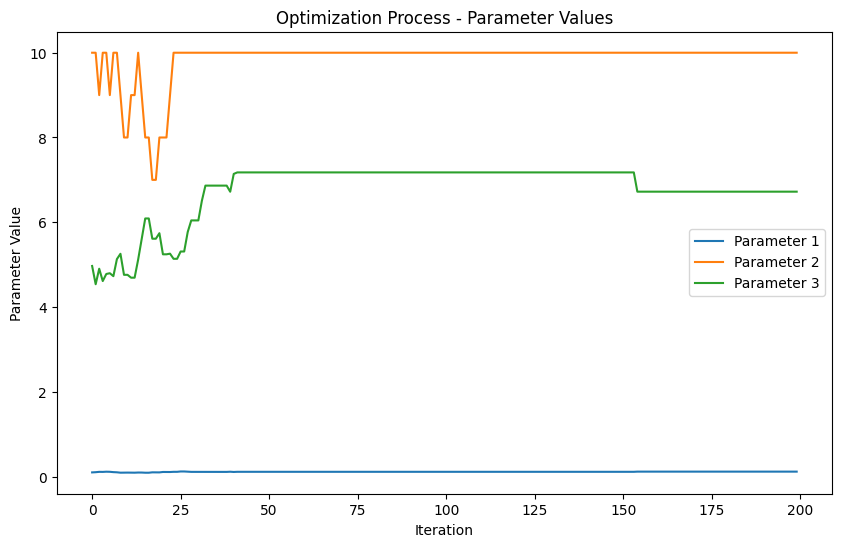

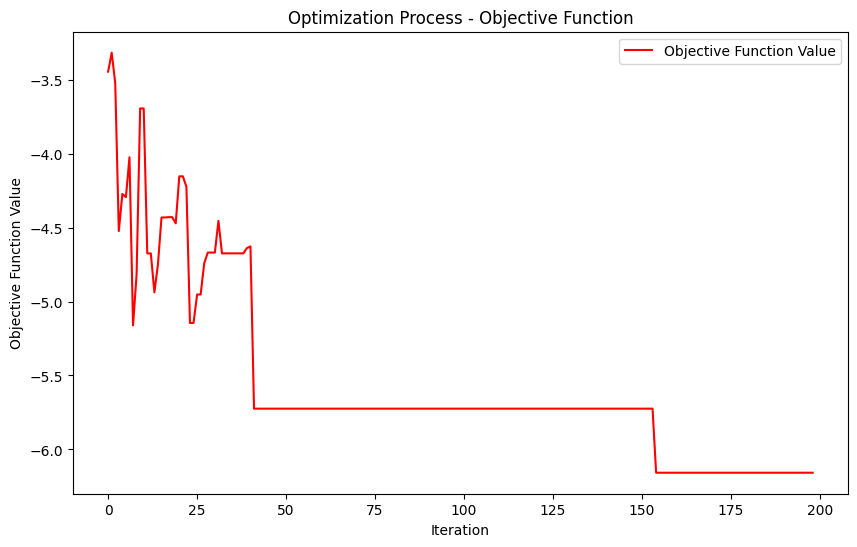

In [42]:
visualize_optimization(num_iterations-1, all_params_hr[:num_iterations], obj_values_hr[:num_iterations-1])

In [43]:
# Example usage
X_train, X_valid, y_train, y_valid = train_df[test_df.columns], test_df, train_df["enhanced_speed"], speed_test 

initial_params = [0.1, 5, 3]  # Initial values for learning_rate, max_depth, min_child_weight
temperature = 1.0
cooling_rate = 0.95
num_iterations = 200

best_params, best_cost, all_params, obj_values = simulated_annealing(initial_params, objective_function, temperature, cooling_rate, num_iterations)

print("Best Parameters:", best_params)
print("Best Score (Mean Absolute Error):", best_cost)
# Example usage:
# Assuming you have recorded parameter_values and objective_values during optimization

100%|██████████| 200/200 [43:46<00:00, 13.13s/it]

Best Parameters: [0.12948638 8.         6.98935583]
Best Score (Mean Absolute Error): -1.004167747034066


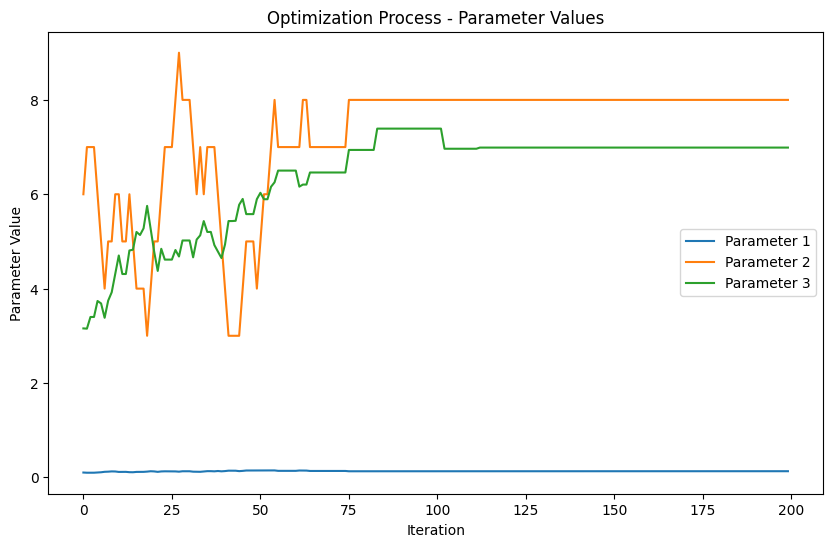

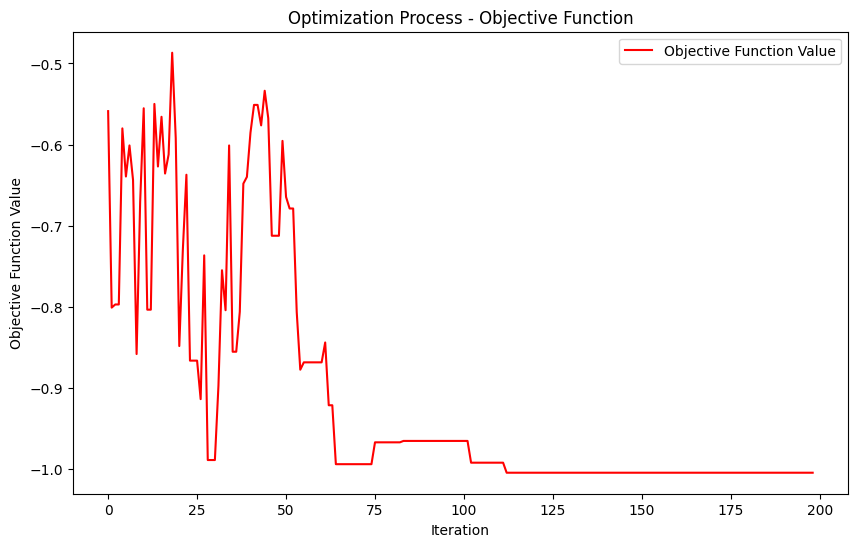

In [44]:
visualize_optimization(num_iterations-1, all_params[:num_iterations], obj_values[:num_iterations-1])